# Simulation and Analysis of Percolation Systems

### Import relevant packages and set random seed

In [292]:
import numpy as np
from scipy import optimize, stats

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget

from collections import Counter
import pickle
import os

np.random.seed(2023)

### Define the percolation algorithm and generate an example

In [293]:
# Set length of the square percolation system
grid_size = 500

# Set p-value used to generate initial percolation system
p_init = 0.5


# Create a map of random colors for displaying clusters
rand_colors = [[0,0,0]] + (np.random.rand(grid_size ** 2, 3) * 255).astype(int).tolist()
cmap = mpl.colors.ListedColormap(rand_colors)


# Initialize a random grid representing the connection values in the dual grid
dual_vals = np.random.rand(grid_size * 2, grid_size)


# Use a depth-first search algorithm to label distinct clusters in the percolation system
def get_percolation(dual_vals, p):
    dual_grid = dual_vals <= p
    percolation = np.zeros((grid_size, grid_size), dtype=int)
    cluster_index = 1
    stack = []
    for i in range(grid_size):
        for j in range(grid_size):
            if percolation[j][i] == 0:
                percolation[j][i] = cluster_index
                stack.append((i, j))
                while stack:
                    x, y = stack.pop()
                    if x > 0 and percolation[y][x-1] == 0 and dual_grid[2*y][x-1]: # Check leftward connection
                        percolation[y][x-1] = cluster_index
                        stack.append((x-1, y))
                    if y > 0 and percolation[y-1][x] == 0 and dual_grid[2*y-1][x]: # Check upward connection
                        percolation[y-1][x] = cluster_index
                        stack.append((x, y-1))
                    if x < grid_size-1 and percolation[y][x+1] == 0 and dual_grid[2*y][x]: # Check rightward connection
                        percolation[y][x+1] = cluster_index
                        stack.append((x+1, y))
                    if y < grid_size-1 and percolation[y+1][x] == 0 and dual_grid[2*y+1][x]: # Check downward connection
                        percolation[y+1][x] = cluster_index
                        stack.append((x, y+1))
                cluster_index += 1
    return percolation


# Generate an example
percolation = get_percolation(dual_vals, p_init)

### Display the percolation system with an interactive slider

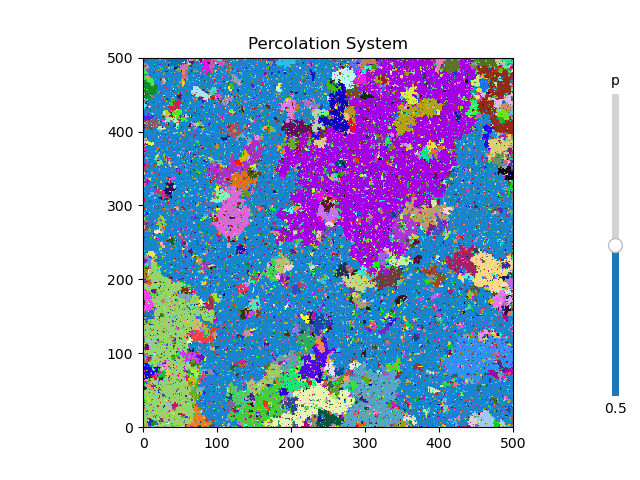

In [294]:
# Set p-value intverval for the interactive slider
p_step = 0.01


# Visualize data with matplotlib
fig, ax = plt.subplots()
ax.set_title("Percolation System")
ax.set_aspect('equal')
ax.pcolormesh(percolation, cmap=cmap)

ax_slider = plt.axes([0.95, 0.175, 0.0225, 0.63])
slider_p = mpl.widgets.Slider(
    ax=ax_slider,
    label='p',
    valmin=0,
    valmax=1,
    valinit=p_init,
    valstep=p_step,
    orientation="vertical"
)

def update(val):
    percolation = get_percolation(dual_vals, p=val)
    ax.pcolormesh(percolation, cmap=cmap)
    
slider_p.on_changed(update)
plt.show()

### Display only the largest clusters with interactive sliders

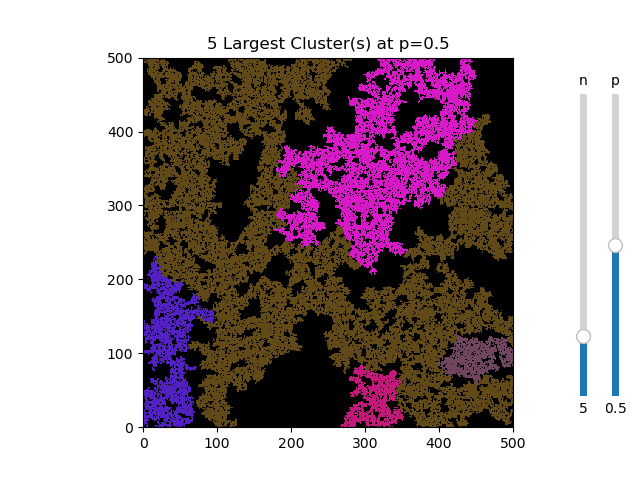

In [295]:
# Only show this many largest clusters
num_clusters_shown = 5

# Get a list of the largest clusters to be shown
ctr = Counter(percolation.ravel())
clusters_shown = np.array(ctr.most_common(num_clusters_shown)).T[0]


# Use vectorization to create a grid of only the largest clusters
def suppress_clusters(cluster):
    if cluster not in clusters_shown:
        return 0
    return cluster

cluster_grid = np.vectorize(suppress_clusters)(percolation)


# Visualize data with matplotlib
p = p_init
fig2, ax2 = plt.subplots()
ax2.set_title(f"{num_clusters_shown} Largest Cluster(s) at p={p}")
ax2.set_aspect("equal")
ax2.pcolormesh(cluster_grid, cmap=cmap)

ax_slider = plt.axes([0.95, 0.175, 0.0225, 0.63])
slider_p = mpl.widgets.Slider(
    ax=ax_slider,
    label='p',
    valmin=0,
    valmax=1,
    valinit=p_init,
    valstep=p_step,
    orientation="vertical"
)

ax_slider2 = plt.axes([0.90, 0.175, 0.0225, 0.63])
slider_n = mpl.widgets.Slider(
    ax=ax_slider2,
    label='n',
    valmin=1,
    valmax=21,
    valinit=num_clusters_shown,
    valstep=[x for x in range(1, 21)],
    orientation="vertical"
)

def update_p(val):
    global p
    global percolation
    global clusters_shown
    
    p = val
    percolation = get_percolation(dual_vals, p=val)
    ctr = Counter(percolation.ravel())
    clusters_shown = np.array(ctr.most_common(num_clusters_shown)).T[0]
    cluster_grid = np.vectorize(suppress_clusters)(percolation)
    
    ax2.set_title(f"{num_clusters_shown} Largest Cluster(s) at p={p}")
    ax2.pcolormesh(cluster_grid, cmap=cmap)
    
def update_n(val):
    global num_clusters_shown
    global clusters_shown
    
    num_clusters_shown = val
    ax2.set_title(f"{num_clusters_shown} Largest Cluster(s) at p={p}")
    clusters_shown = np.array(ctr.most_common(num_clusters_shown)).T[0]
    cluster_grid = np.vectorize(suppress_clusters)(percolation)
    
    ax2.pcolormesh(cluster_grid, cmap=cmap)
    
slider_p.on_changed(update_p)
slider_n.on_changed(update_n)
plt.show()

### Preview the cluster size distributions in percolation systems near criticality

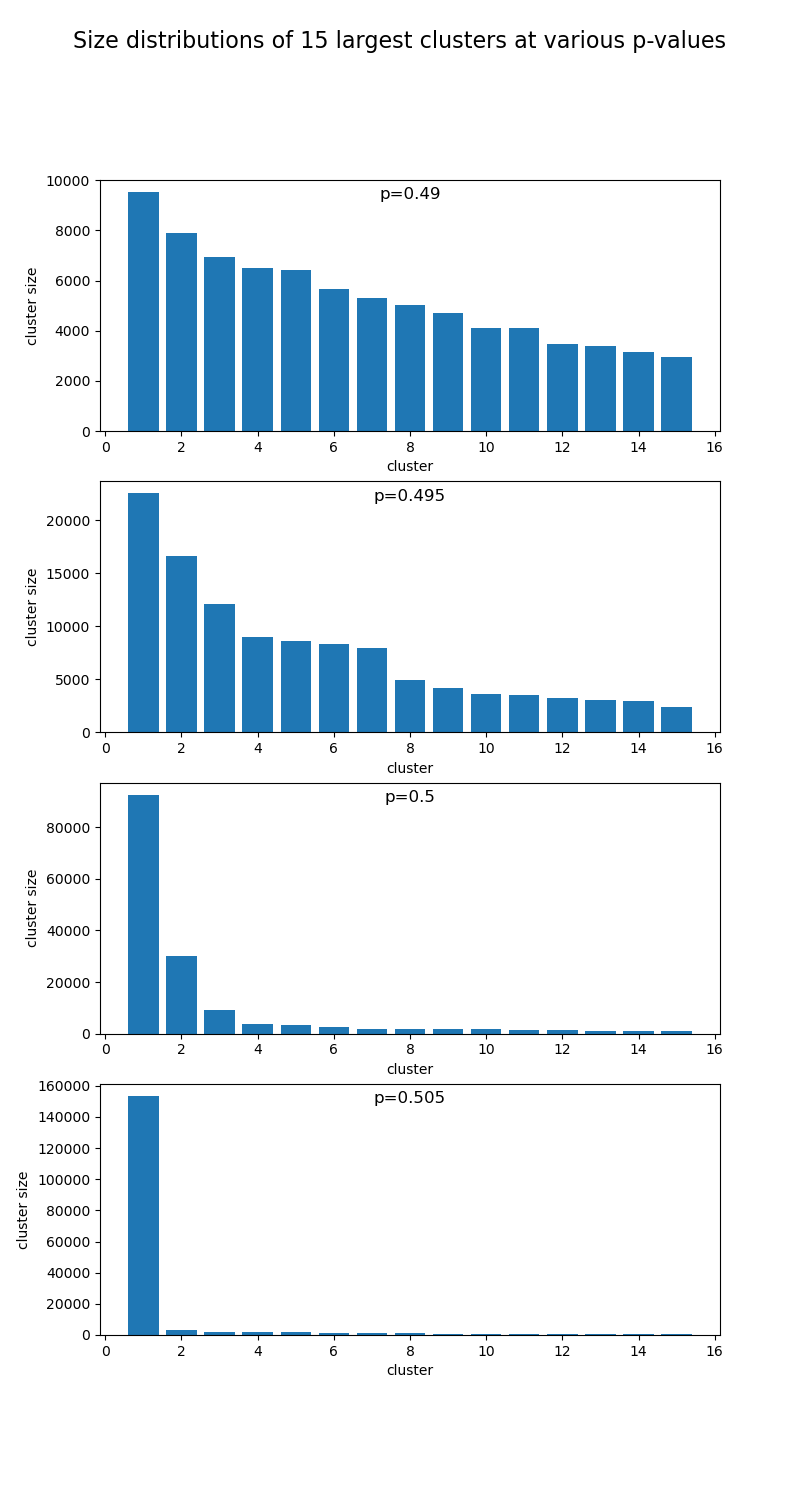

In [296]:
# Only show this many largest clusters
num_clusters_shown = 15


# Visualize data using bar charts with matplotlib
fig3, ax3 = plt.subplots(4, 1)
fig3.suptitle(f"Size distributions of {num_clusters_shown} largest clusters at various p-values", fontsize=16)

for i in range(4):
    p = [0.49, 0.495, 0.5, 0.505][i]
    percolation = get_percolation(dual_vals, p)
    ctr = Counter(percolation.ravel())
    cluster_sizes = np.array(ctr.most_common(num_clusters_shown)).T
    ax3[i].set_title(f"p={p}", y=1, pad=-14)
    ax3[i].set_xlabel('cluster')
    ax3[i].set_ylabel('cluster size')
    ax3[i].figure.set_size_inches(8, 15)
    ax3[i].bar([rank for rank in range(1, len(cluster_sizes[0]) + 1)], cluster_sizes[1])

plt.show()

### Record cluster size distributions for a range of p-values

In [297]:
# Set the minimum p-value to sample data for
p_min = 0.35 

# Set the maximum p-value to sample data for
p_max = 0.65

# Set the number of p-values to sample data for in the inverval [p_min, p_max]
p_points = 500

# Set the number of trials to average cluster size over
num_trials = 5

# Define the range of p-values to sample
p_range = np.linspace(p_min, p_max, p_points)

In [ ]:
# Warning: this cell may take a while to run

# Collect cluster size distribution data across `p_range`
cluster_data = np.zeros((p_range.size, num_trials, grid_size**2))
for p_row, p in enumerate(p_range):
    for trial in range(num_trials):
        dual_vals = np.random.rand(grid_size * 2, grid_size)
        percolation = get_percolation(dual_vals, p)
                
        ctr = Counter(percolation.ravel())
        cluster_sizes = np.array(ctr.most_common()).T[1]

        cluster_data[p_row][trial][:cluster_sizes.size] = cluster_sizes

### Save cluster data

In [102]:
pickle.dump(cluster_data, open(f'data\cluster-distributions\cluster_data-{grid_size}-{p_min}-{p_max}-{p_points}-{num_trials}.pkl', 'wb'))

### Load existing cluster data

In [298]:
cluster_data = pickle.load(open(f'data\cluster-distributions\cluster_data-500-0.35-0.65-500-5.pkl', 'rb'))

### Use least-squares regression to fit curves to the distribution of largest cluster size versus p-value

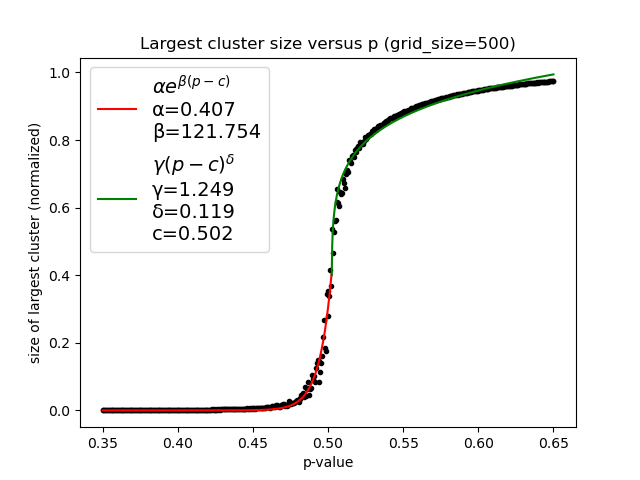

In [33]:
# Average cluster data over trails
avg_cluster_data = np.average(cluster_data, axis=1)

# Select only the largest clusters for each p-value and normalize data
avg_largest_cluster_data_normalized = avg_cluster_data.T[0] / grid_size**2


# Define functions to model data
def exponential(p, A, B, C, D, pc):
    return A * np.exp(B * (p - pc))

def power_law(p, A, B, C, D, pc):
    return C * (p - pc)**D

def piecewise_function(p, A, B, C, D, pc):
    return np.piecewise(p, [p < pc, p >= pc], [exponential, power_law], A, B, C, D, pc)


# Use scipy to perform least-squares regression and extract coefficients
func_to_fit = piecewise_function
popt, _ = optimize.curve_fit(func_to_fit, p_range, avg_largest_cluster_data_normalized, p0=[1, 1, 1, 1, 0.5])
A, B, C, D, pc = popt


# Visualize data with matplotlib
fig4, ax4 = plt.subplots()
ax4.set_title(f"Largest cluster size versus p (grid_size={grid_size})")
ax4.scatter(p_range, avg_largest_cluster_data_normalized, color="black", marker='.')

x_left = np.linspace(p_min, popt[-1]-7e-5, 1000)
x_right = np.linspace(popt[-1]+7e-5, p_max, 1000)
ax4.plot(x_left, func_to_fit(x_left, *popt), color='red', label=f'$αe^{{β(p-c)}}$\nα={A:.3f}\nβ={B:.3f}')
ax4.plot(x_right, func_to_fit(x_right, *popt), color='green', label=f'$γ(p-c)^δ$\nγ={C:.3f}\nδ={D:.3f}\nc={pc:.3f}')

ax4.set_xlabel('p-value')
ax4.set_ylabel('size of largest cluster (normalized)')
plt.legend(prop={'size': 14})
plt.show()

### Use least-squares regression to fit an inverse power law to cluster size distributions

C:\Users\andre\AppData\Local\Temp\ipykernel_31028\2089330535.py:9: RuntimeWarning: overflow encountered in power
  result[mask] = A * x[mask] ** -k + B*(x[mask] - C)
C:\Users\andre\AppData\Local\Temp\ipykernel_31028\2089330535.py:9: RuntimeWarning: overflow encountered in multiply
  result[mask] = A * x[mask] ** -k + B*(x[mask] - C)


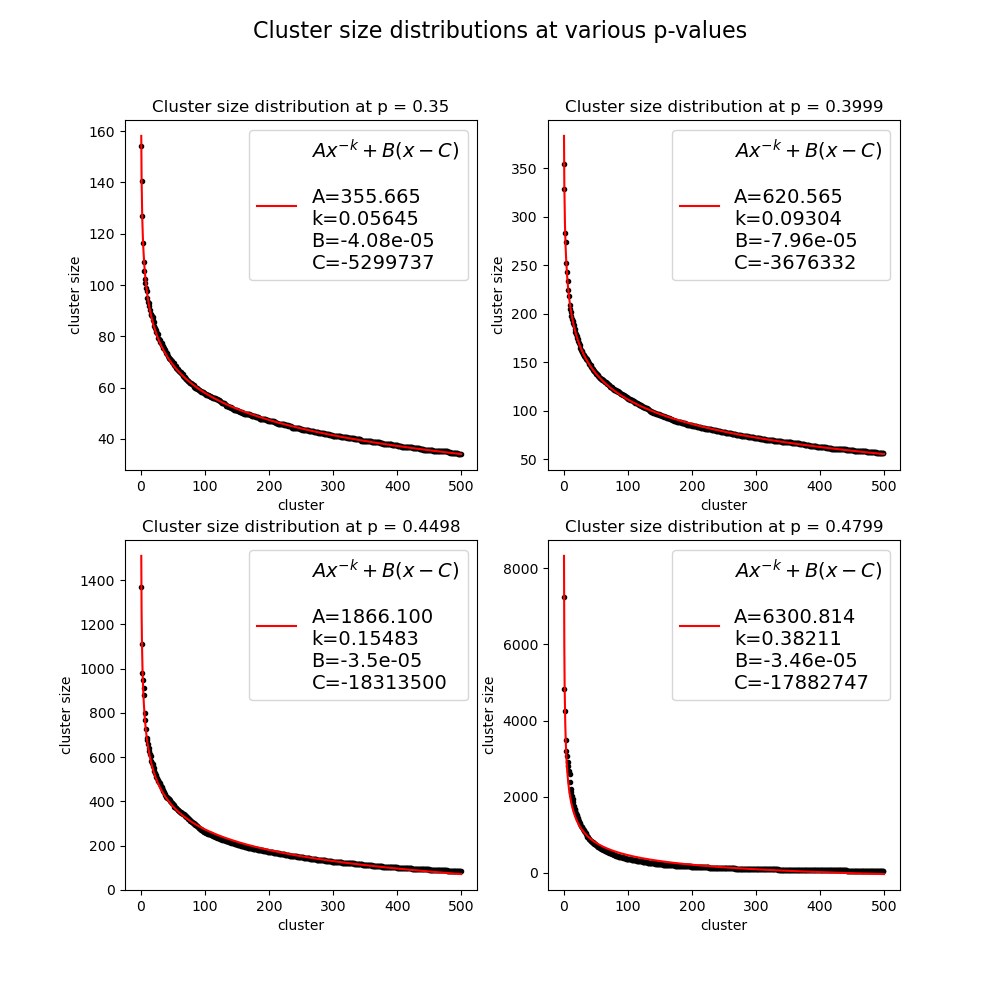

In [299]:
# Set the number of largest clusters to fit the curve to
num_clusters = 500


# Define an inverse power law which doesn't explode at x = 0
def inverse_power_law(x, A, B, C, k):
    mask = (x >= 0.01)
    result = np.zeros_like(x)
    result[mask] = A * x[mask] ** -k + B*(x[mask] - C)
    return result

func_to_fit = inverse_power_law


# Convert iterative index to axes position for plotting
def index_to_pos(i):
    return [(0, 0), (0, 1), (1, 0), (1, 1)][i]


# Visualize data using matplotlib
fig6, ax6 = plt.subplots(2, 2)
fig6.suptitle("Cluster size distributions at various p-values", fontsize=16)
discrete_range = [e for e in range(num_clusters)]
for i, p in enumerate([0.35, 0.4, 0.45, 0.48]):
    p_index = np.where(np.isclose(p_range, p, atol=0.0005))[0][0]
    
    # Use scipy to perform least-squares regression and extract coefficients
    popt, _ = optimize.curve_fit(func_to_fit, discrete_range, avg_cluster_data[p_index][:num_clusters], maxfev=100000)
    A, B, C, k = popt

    ax_x, ax_y = index_to_pos(i)
    ax6[ax_x][ax_y].set_title(f"Cluster size distribution at p = {p_range[p_index]:.4}")
    ax6[ax_x][ax_y].set_xlabel('cluster')
    ax6[ax_x][ax_y].set_ylabel('cluster size')
    ax6[ax_x][ax_y].scatter(discrete_range, avg_cluster_data[p_index][:num_clusters], color="black", marker='.')

    x = np.linspace(0.4, num_clusters, 1000)
    ax6[ax_x][ax_y].plot(x, func_to_fit(x, *popt), color='red', label=f'$Ax^{{-k}} + B(x-C)$\n\nA={A:.3f}\nk={k:.5f}\nB={B:.3}\nC={C:.0f}')
    ax6[ax_x][ax_y].figure.set_size_inches(10, 10)
    ax6[ax_x][ax_y].legend(prop={'size': 14})

plt.show()

### Record the exponential parameters k which best fits the distribution for various p-values

In [309]:
# Set the number of p-values to sample
p_points = 200

In [ ]:
# Warning: this cell may take a while to run
func_to_fit = inverse_power_law

# Iterate over p-values and extract coefficient k
k_values = []
for clusters in avg_cluster_data[:p_points]:
    popt, _ = optimize.curve_fit(func_to_fit, discrete_range, clusters[:num_clusters], maxfev=100000)
    k_values.append(popt[3])

### Save k-value data

In [ ]:
pickle.dump(k_values, open(f'data\k-values\k_values_data-{grid_size}-{p_min}-{p_max}-{p_points}.pkl', 'wb'))

### Load existing k-value data

In [310]:
cluster_data = pickle.load(open(f'data\k-values\k_values_data-500-0.35-0.65-200.pkl', 'rb'))

### Use least-squares regression to best fit a power law to the exponent k

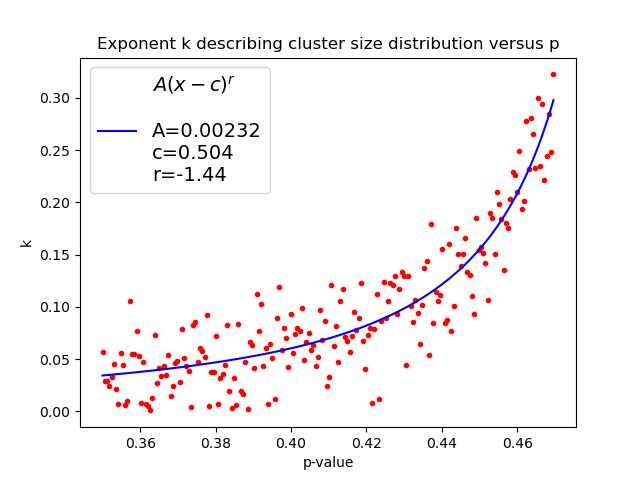

In [311]:
# Define the function to fit k versus p data
def power_law(x, A, r, c):
    return A * abs(x-c) ** r

func_to_fit = power_law


# Use scipy to perform linear regression on k versus p-value data
popt, _ = optimize.curve_fit(func_to_fit, p_range[:p_points], k_values)
A, r, c = popt


# Visualize data using matplotlib
fig7, ax7 = plt.subplots()
ax7.set_title("Exponent k describing cluster size distribution versus p")
ax7.set_xlabel('p-value')
ax7.set_ylabel('k')

ax7.plot(p_range[:p_points], func_to_fit(p_range[:p_points], *popt), color='blue', label=f'$A(x-c)^r$\n\nA={A:.3}\nc={c:.3}\nr={r:.3}')    
plt.legend(prop={'size': 14})
ax7.scatter(p_range[:p_points], k_values, color='red', marker='.')
plt.show()

`c` = 0.504 indicates that this function diverges as `p-value` approaches 0.504. This confirms the existence of a phase transition at the critical `p-value` = 0.5. Greater than this critical value, there is effectively one largest cluster. This is reflected in the cluster size distribution as one initial large value, followed only by numbers close to zero, and hence the parameter `k` is no longer useful in this region. However, below the critical threshold, `k` accurately captures the distribution of cluster sizes.

# Using a neural network to predict p-values from percolation images

In [249]:
# Set the number of percolation images to generate
num_images = 100_000

# Set the grid size of every image
grid_size = 32

# Set the range of p-values to train and test the model on
p_range = (0.3, 0.7)

### Generate image and label data

In [250]:
# Warning: this cell may take a while to run

# Fill an array with random p-values in the range
labels = np.random.rand(num_images) * (p_range[1] - p_range[0]) + p_range[0]

# Initialize the images with zero matrices
images = np.zeros((num_images, grid_size, grid_size))

# Populate `images` with percolation systems corresponding to the p-values in `labels`
for i in range(num_images):
    dual_vals = np.random.rand(grid_size * 2, grid_size)
    images[i] = get_percolation(dual_vals, p=labels[i])

### Save label and image data

In [251]:
pickle.dump(labels, open(f'data\labels\labels-{grid_size}-{p_range}-{num_images}.pkl', 'wb'))
pickle.dump(images, open(f'data\images\images-{grid_size}-{p_range}-{num_images}.pkl', 'wb'))

### Load existing label and image data

In [104]:
labels = pickle.load(open(f'data\labels\labels-32-(0.3, 0.7)-100000.pkl', 'rb'))
images = pickle.load(open(f'data\images\images-32-(0.3, 0.7)-100000.pkl', 'rb'))

### Partition and preprocess the datasets

In [271]:
# Partition the sets of image and label data, with more training than testing data
train_images = images[:int(num_images//1.3)] # / (grid_size**2 - 1)
train_labels = labels[:int(num_images//1.3)]
test_images = images[int(num_images//1.3):] # / (grid_size**2 - 1)
test_labels = labels[int(num_images//1.3):]

# Set the number of output classes. Greater values correspond to demanding more precise p-values
# At 11, with a `p_range` of (0.3, 0.7), p-values must be identified within a 0.04 interval to be considered correct
num_classes = 11

# Use one-hot encoding to convert p-values to arrays with positional representation
OH_train_labels = tf.one_hot(((train_labels - p_range[0]) / (p_range[1] - p_range[0]) * num_classes).astype(np.int32), depth=num_classes)
OH_test_labels = tf.one_hot(((test_labels - p_range[0]) / (p_range[1] - p_range[0]) * num_classes).astype(np.int32), depth=num_classes)

In [272]:
# Preserve the correspondence of cluster labels while disregarding their magnitude
def randomize_values(percolation):
    unique_values = np.unique(percolation)
    random_values = np.random.rand(len(unique_values))
    value_map = dict(zip(unique_values, random_values))
    randomized_percolation = np.vectorize(value_map.__getitem__)(percolation)
    return randomized_percolation

# Preprocess all images
for i, image in enumerate(train_images):
    train_images[i] = randomize_matrix_values(image)
for i, image in enumerate(test_images):
    test_images[i] = randomize_matrix_values(image)

### Preview a sample of the data

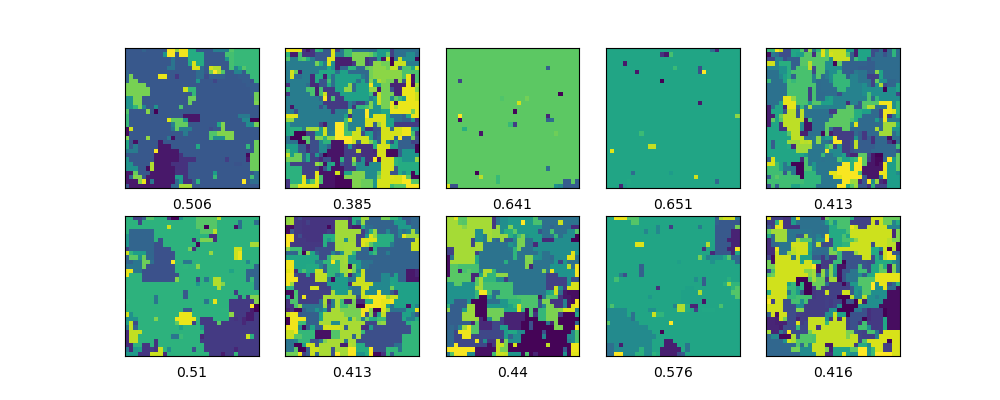

In [273]:
# Visualize data using matplotlib
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(train_images[i], cmap='viridis')
    plt.xlabel(f"{train_labels[i]:.3}")
plt.show()

### Build a convolutional neural network

In [276]:
M3 = tf.keras.models.Sequential([
    layers.Input(shape=(grid_size, grid_size, 1)),
    
    # Three sets of convolutional and max-pooling layers
    layers.Conv2D(32, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    # Two dense layers with 50% dropout rates to prevent overfitting
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

### Compile and train the model

In [277]:
model = M4
epochs = 10

model.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, OH_train_labels, epochs=epochs, 
                    validation_data=(test_images, OH_test_labels))


Epoch 1/10
2404/2404 [==============================] - 35s 14ms/step - loss: 1.2848 - accuracy: 0.4428 - val_loss: 0.9281 - val_accuracy: 0.5721
Epoch 2/10
2404/2404 [==============================] - 36s 15ms/step - loss: 1.0590 - accuracy: 0.5191 - val_loss: 0.9380 - val_accuracy: 0.5635
Epoch 3/10
2404/2404 [==============================] - 52s 22ms/step - loss: 1.0018 - accuracy: 0.5467 - val_loss: 0.8861 - val_accuracy: 0.6042
Epoch 4/10
2404/2404 [==============================] - 35s 14ms/step - loss: 0.9723 - accuracy: 0.5615 - val_loss: 0.8754 - val_accuracy: 0.6076
Epoch 5/10
2404/2404 [==============================] - 37s 15ms/step - loss: 0.9457 - accuracy: 0.5745 - val_loss: 0.8859 - val_accuracy: 0.5986
Epoch 6/10
2404/2404 [==============================] - 33s 14ms/step - loss: 0.9173 - accuracy: 0.5863 - val_loss: 0.9040 - val_accuracy: 0.5886
Epoch 7/10
2404/2404 [==============================] - 35s 15ms/step - loss: 0.8971 - accuracy: 0.5961 - val_loss: 0.8247 -

### Save model weights

In [278]:
checkpoint_path = f"data\model-weights\cp-{grid_size}-{num_classes}-{epochs}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.save_weights(checkpoint_path)

### Load existing model weights

In [267]:
model.load_weights(f"data\model-weights\cp-32-11-10.ckpt")

### Display the accuracy over the training period

722/722 - 3s - loss: 0.8475 - accuracy: 0.6239 - 3s/epoch - 4ms/step


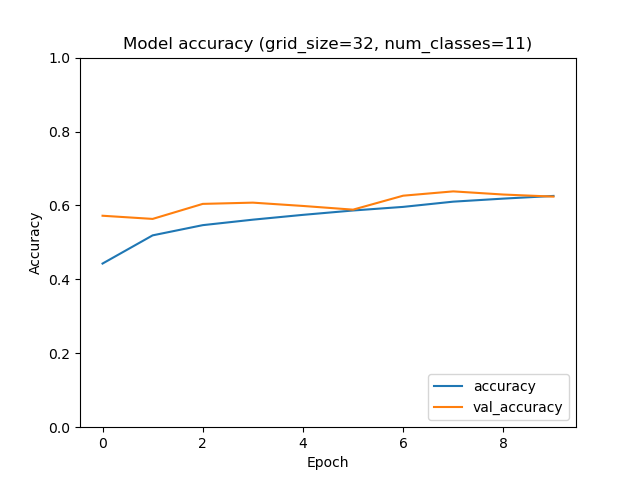

In [279]:
fig_ml, ax_ml = plt.subplots()

ax_ml.plot(history.history['accuracy'], label='accuracy')
ax_ml.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax_ml.set_title(f'Model accuracy (grid_size={grid_size}, num_classes={num_classes})')
ax_ml.set_xlabel('Epoch')
ax_ml.set_ylabel('Accuracy')
ax_ml.set_ylim([0, 1])
ax_ml.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  OH_test_labels, verbose=2)

### Preview the accuracy for a sample of the test data

Although the model is only achieving 62% accuracy and validation accuracy, incorrect answers are often very close. We can verify this by finding the mean error of the model's predictions on unseen data.

In [280]:
samples = 10
error = np.zeros(samples)
for i in range(samples):
    reshaped_image = np.reshape(test_images[i], (1, grid_size, grid_size, 1))
    predicted_p = (np.argmax(model.predict(reshaped_image, verbose=0)) / (num_classes - 1)) * (p_range[1] - p_range[0]) + p_range[0]
    actual_p = test_labels[i]
    error[i] = 100 * np.abs(predicted_p - actual_p) / actual_p
    print(f"Test Image {i}: actual = {actual_p:.4}\n           predicted = {predicted_p:.4}\n               error = {error[i]:.3} %\n")

print(f"Mean error of {samples} samples: {np.mean(error):.4} %")

Test Image 0: actual = 0.3776
           predicted = 0.38
               error = 0.636 %

Test Image 1: actual = 0.4465
           predicted = 0.38
               error = 14.9 %

Test Image 2: actual = 0.6925
           predicted = 0.7
               error = 1.08 %

Test Image 3: actual = 0.558
           predicted = 0.54
               error = 3.23 %

Test Image 4: actual = 0.6002
           predicted = 0.62
               error = 3.3 %

Test Image 5: actual = 0.4089
           predicted = 0.38
               error = 7.06 %

Test Image 6: actual = 0.4575
           predicted = 0.46
               error = 0.537 %

Test Image 7: actual = 0.3729
           predicted = 0.38
               error = 1.91 %

Test Image 8: actual = 0.5464
           predicted = 0.54
               error = 1.17 %

Test Image 9: actual = 0.5969
           predicted = 0.66
               error = 10.6 %

Mean error of 10 samples: 4.439 %


In [281]:
# Increase the number of samples to more accurately capture the % error
samples = 200
error = np.zeros(samples)
for i in range(samples):
    reshaped_image = np.reshape(test_images[i], (1, grid_size, grid_size, 1))
    predicted_p = (np.argmax(model.predict(reshaped_image, verbose=0)) / (num_classes - 1)) * (p_range[1] - p_range[0]) + p_range[0]
    actual_p = test_labels[i]
    error[i] = 100 * np.abs(predicted_p - actual_p) / actual_p
    
print(f"Mean error of {samples} samples: {np.mean(error):.4} %")

Mean error of 200 samples: 4.196 %


This model is able to recognize p-values from image data with an average of 4.196 % error.